In [2]:
from DataParser import DataParser
import numpy as np
import pandas as pd
import scipy.sparse as sp

from Base.Evaluation.Evaluator import EvaluatorHoldout
from Data_manager.split_functions.split_train_validation_random_holdout import \
split_train_in_two_percentage_global_sample

from KNN.ItemKNNCBFRecommender import ItemKNNCBFRecommender
from Base.NonPersonalizedRecommender import TopPop
from SLIM_ElasticNet.SLIMElasticNetRecommender import SLIMElasticNetRecommender
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams.update({'font.size': 40})

%matplotlib inline

In [3]:
seed = 1024
parser = DataParser()

URM_all = parser.get_URM_all()
ICM_all = parser.get_ICM_all()

URM_train, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage=0.85, seed=seed)

evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

In [4]:
mat = URM_all.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_n = frame.groupby(['user_id']).size().reset_index(name='num_inter')

In [3]:
#frame_n.loc[frame_n['num_inter'] < 2]

In [4]:
mat = URM_train.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame = pd.DataFrame(data=d)
frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

mat = URM_test.tocoo()
d={'user_id':mat.row,
   'item_id':mat.col,
   'rating':mat.data}
frame_test = pd.DataFrame(data=d)
frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
#frame_join

In [5]:
def split_datasets(frame, size = 20):
    max_value = frame['num_inter'].max()
    frame_list=[]
    start_value = 0
    while start_value <= max_value:
        end_value = start_value+size
        sub_frame = frame_join.loc[(frame_join['num_inter'] >= start_value) & (frame_join['num_inter'] < end_value)].iloc[:,:3]
        if not sub_frame.empty:
            t = (start_value, end_value, sub_frame)
        else:
            t = (start_value, end_value, None)
        frame_list.append(t)
        start_value = end_value
    return frame_list

In [6]:
def compute_map_per_range(recommender, URM_test, range_size=20):
    map_list=[]
    
    URM_train = recommender.get_URM_train()
    mat = URM_train.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame = pd.DataFrame(data=d)
    frame_train = frame.groupby(['user_id']).size().reset_index(name='num_inter')

    mat = URM_test.tocoo()
    d={'user_id':mat.row,
       'item_id':mat.col,
       'rating':mat.data}
    frame_test = pd.DataFrame(data=d)
    frame_join = frame_test.join(frame_train.set_index('user_id'), on='user_id')
    
    frame_list = split_datasets(frame_join, range_size)
    
    for (start_value, end_value, sub_frame) in frame_list:
        if sub_frame is None:
            frame_map = None
            frame_len = None
        else:
            frame_len = len(sub_frame.user_id.unique())
            partial_urm_test = sp.csr_matrix((sub_frame.rating, (sub_frame.user_id, sub_frame.item_id)), 
                              shape=URM_train.shape)
            evaluator_test = EvaluatorHoldout(partial_urm_test, cutoff_list=[10])
            result, _ = evaluator_test.evaluateRecommender(recommender)
            frame_map = result[10]['MAP']
        map_list.append((start_value, end_value, frame_map, frame_len))
    
    return map_list
    

In [7]:
def frame_to_plot(map_list):
    x = []
    y = []
    z = []
    for (low, high, val, support) in map_list:
        x_val = str(low)+'-'+str(high)
        if val is None:
            #y.append(0)
            continue
        else:
            y.append(val)
        x.append(x_val)
        z.append(support)
    return x,y,z

In [35]:
def plot_frame(x,y):
    #figure(num=None, figsize=(100, 20), dpi=80, facecolor='w', edgecolor='k')
    #igure(figsize=(50,20))
    axes = plt.gca()
    #axis_font = {'fontname':'Arial', 'size':'22'}
    #axes.set_ylim([0,0.3])
    #axes.tick_params(axis='both', labelsize='large')
    plt.setp(axes.get_xticklabels(), rotation='vertical', fontsize=14)
    
    plt.bar(x, y) #, align='center'
    plt.xticks(range(len(x)), x)

In [9]:
rec1 = ItemKNNCBFRecommender(URM_train, ICM_all)
rec1.fit(topK=40, shrink=1000, similarity='cosine', feature_weighting='BM25')
result_eval, _ = evaluator_test.evaluateRecommender(rec1) 

ItemKNNCBFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCBFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 4812.78 column/sec, elapsed time 0.09 min
EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.85 sec. Users per second: 1757


In [10]:
map_list_knn = compute_map_per_range(rec1, URM_test, range_size=30)
x_knn,y_knn,_ = frame_to_plot(map_list_knn)
frame_knn = pd.DataFrame({'range':x_knn, 'MAP':y_knn})
#frame_knn

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.90 sec. Users per second: 1503
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.27 sec. Users per second: 1359
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.09 sec. Users per second: 1191
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.04 sec. Users per second: 1052
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.02 sec. Users per second: 948
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.02 sec. Users per second: 928
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 781
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 417
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 286
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 473
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 114
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 247


/home/filippo/challenge/RecSys-2020/Base/Evaluation/metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 303
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 150
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 223
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 132
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 198
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 125
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 118
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 154


In [39]:
rec_elasticnet = SLIMElasticNetRecommender(URM_train)
rec_elasticnet.fit(topK=120, l1_ratio=1e-5, alpha=0.066)


SLIMElasticNetRecommender: URM Detected 42 (0.53 %) cold users.
SLIMElasticNetRecommender: URM Detected 1971 (7.59 %) cold items.
SLIMElasticNetRecommender: Processed 9309 ( 35.84% ) in 5.00 min. Items per second: 31.03
SLIMElasticNetRecommender: Processed 18904 ( 72.78% ) in 10.00 min. Items per second: 31.50
SLIMElasticNetRecommender: Processed 25975 ( 100.00% ) in 13.65 min. Items per second: 31.72


In [40]:
mappone = compute_map_per_range(rec_elasticnet, URM_test, range_size=30)
x_slim,y_slim,_ = frame_to_plot(mappone)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 3.33 sec. Users per second: 1309
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.39 sec. Users per second: 947
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.10 sec. Users per second: 1028
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.04 sec. Users per second: 1088
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.03 sec. Users per second: 801
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.02 sec. Users per second: 878
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 845
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 592
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 433
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 558
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 202
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 345


/home/filippo/challenge/RecSys-2020/Base/Evaluation/metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 382
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 186
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 308
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 172
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 294
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 181
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 183
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 173


In [13]:
from GraphBased.RP3betaRecommender import RP3betaRecommender
recommender_apr = RP3betaRecommender(URM_train)
recommender_apr.fit(alpha=0.4530815441932864,  beta=0.008742088319964482, topK=104, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [14]:
list2=compute_map_per_range(recommender_apr, URM_test, range_size=30)
x_apr,y_apr,_ = frame_to_plot(list2)
#pd.DataFrame({'range':x, 'MAP':y})

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.34 sec. Users per second: 1862
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.22 sec. Users per second: 1705
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.06 sec. Users per second: 1803
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.03 sec. Users per second: 1333
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.02 sec. Users per second: 1133
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.02 sec. Users per second: 1070
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.02 sec. Users per second: 835
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 746
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 289
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 421
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 133
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.00 sec. Users per second: 414


/home/filippo/challenge/RecSys-2020/Base/Evaluation/metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 300
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 226
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 248
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 234
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 270
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 199
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.00 sec. Users per second: 206
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 144


In [15]:
from KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
#'topK': 967, 'shrink': 356, 'similarity': 'cosine', 'normalize': True
recommender_cf_knn = ItemKNNCFRecommender(URM_train)
recommender_cf_knn.fit(topK=967, shrink=356, similarity='cosine', normalize=True)

ItemKNNCFRecommender: URM Detected 42 (0.53 %) cold users.
ItemKNNCFRecommender: URM Detected 1971 (7.59 %) cold items.
Similarity column 25975 ( 100 % ), 7489.84 column/sec, elapsed time 0.06 min


In [16]:
list_cf=compute_map_per_range(recommender_cf_knn, URM_test, range_size=30)
x_cf,y_cf,_ = frame_to_plot(list_cf)

EvaluatorHoldout: Processed 4362 ( 100.00% ) in 2.83 sec. Users per second: 1542
EvaluatorHoldout: Processed 368 ( 100.00% ) in 0.34 sec. Users per second: 1095
EvaluatorHoldout: Processed 104 ( 100.00% ) in 0.11 sec. Users per second: 978
EvaluatorHoldout: Processed 41 ( 100.00% ) in 0.05 sec. Users per second: 850
EvaluatorHoldout: Processed 23 ( 100.00% ) in 0.03 sec. Users per second: 720
EvaluatorHoldout: Processed 19 ( 100.00% ) in 0.03 sec. Users per second: 625
EvaluatorHoldout: Processed 15 ( 100.00% ) in 0.03 sec. Users per second: 560
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 361
EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.01 sec. Users per second: 267
EvaluatorHoldout: Processed 5 ( 100.00% ) in 0.01 sec. Users per second: 368
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 100
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 174


/home/filippo/challenge/RecSys-2020/Base/Evaluation/metrics.py:947: RuntimeWarning: invalid value encountered in double_scalars
  self.diversity = diversity_cumulative/all_user_couples_count


EvaluatorHoldout: Processed 3 ( 100.00% ) in 0.02 sec. Users per second: 200
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 135
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 141
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 126
EvaluatorHoldout: Processed 2 ( 100.00% ) in 0.01 sec. Users per second: 154
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 96
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 96
EvaluatorHoldout: Processed 1 ( 100.00% ) in 0.01 sec. Users per second: 86


#### ItemKNNCBF

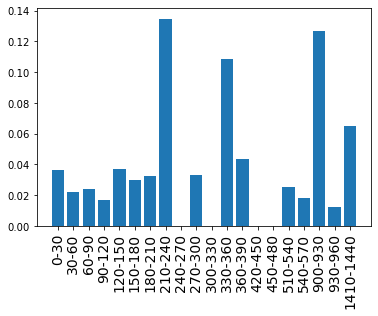

In [36]:
plot_frame(x_knn,y_knn)

#### ItemKNNCF

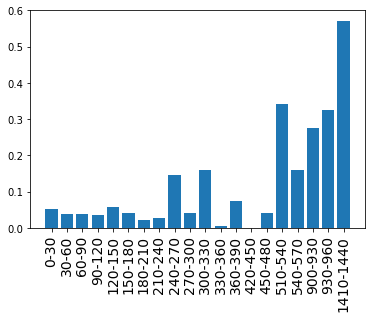

In [37]:
plot_frame(x_cf,y_cf)

#### SLIM ELASTICNET

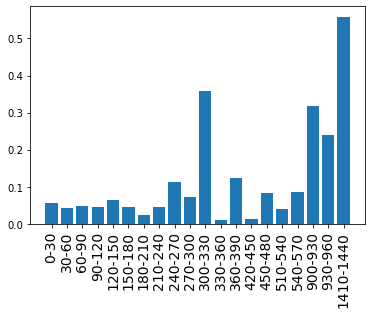

In [41]:
plot_frame(x_slim,y_slim)

#### PageRank

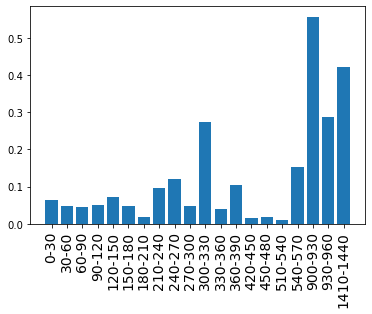

In [38]:
plot_frame(x_apr,y_apr)

In [63]:
result_eval, _ = evaluator_test.evaluateRecommender(rec1)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.67 sec. Users per second: 1871


0.03492096280031698

In [65]:
result_eval, _ = evaluator_test.evaluateRecommender(rec_elasticnet)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.94 sec. Users per second: 1704


0.05483607952006887

In [19]:
result_eval, _ = evaluator_test.evaluateRecommender(recommender_apr)
result_eval[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.67 sec. Users per second: 1871


0.06227232563764613

---

In [4]:
from GraphBased.RP3betaRecommender import RP3betaRecommender
recommender_apr_1 = RP3betaRecommender(URM_train)
recommender_apr_1.fit(alpha=0.4530815441932864,  beta=0.008742088319964482, topK=104, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [5]:
recommender_apr_2 = RP3betaRecommender(URM_train)
#topK': 946, 'alpha': 0.47193263239089045, 'beta': 0.0316773658685341, 'normalize_similarity': False
recommender_apr_2.fit(alpha=0.47193263239089045,  beta=0.0316773658685341, topK=946, normalize_similarity=False)

RP3betaRecommender: URM Detected 42 (0.53 %) cold users.
RP3betaRecommender: URM Detected 1971 (7.59 %) cold items.


In [6]:
result_eval_1, _ = evaluator_test.evaluateRecommender(recommender_apr_1)
'1',result_eval_1[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 2.69 sec. Users per second: 1861


('1', 0.06227232563764613)

In [7]:
result_eval_2, _ = evaluator_test.evaluateRecommender(recommender_apr_2)
'2',result_eval_1[10]['MAP']

EvaluatorHoldout: Processed 5002 ( 100.00% ) in 3.09 sec. Users per second: 1620


('2', 0.06227232563764613)